In [36]:
#Make ARIMA model over shampoo sales data and check the MSE between predicted and actual value.

#Import the required libraries
import pandas as pd
from pandas import datetime
import matplotlib.pyplot as plt
from pandas.tools.plotting import autocorrelation_plot
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
%matplotlib inline

#Define the date parsing function
def parser(x):
    return datetime.strptime('190'+x, '%Y-%m')

In [37]:
#Load the dataset
series = pd.read_csv('shampoo-sales.csv', header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)
series.head()

Month
1901-01-01    266.0
1901-02-01    145.9
1901-03-01    183.1
1901-04-01    119.3
1901-05-01    180.3
Name: Sales of shampoo over a three year period, dtype: float64

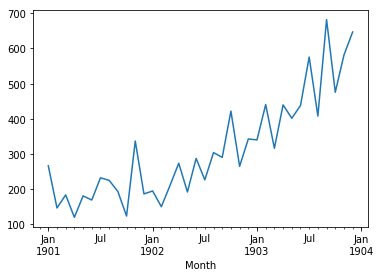

In [38]:
#Plot the dataset
series.plot()

#The graph shows that there is a clear upward trend. 
#Thus the timeseries is not stationary and would require differencing to make it stationary, at least a difference order of 1

C:\Users\nkanodia\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: 'pandas.tools.plotting.autocorrelation_plot' is deprecated, import 'pandas.plotting.autocorrelation_plot' instead.
  


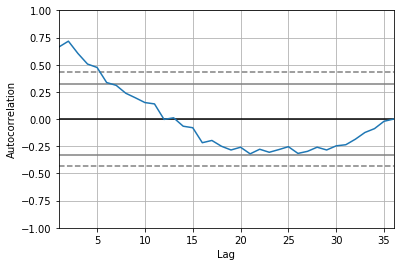

In [39]:
#View the autocorrelation plot
autocorrelation_plot(series)

#There is a positive correlation with the first 10-to-12 lags that is perhaps significant for the first 5 lags.
#A good starting point for the AR parameter of the model may be 5.

In [47]:
#Fit the ARIMA model
model = ARIMA(series, order=(5,1,0))
model_fit = model.fit(disp=0)
print(model_fit.summary())

C:\Users\nkanodia\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\nkanodia\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


                                          ARIMA Model Results                                          
Dep. Variable:     D.Sales of shampoo over a three year period   No. Observations:                   35
Model:                                          ARIMA(5, 1, 0)   Log Likelihood                -196.170
Method:                                                css-mle   S.D. of innovations             64.241
Date:                                         Fri, 05 Jul 2019   AIC                            406.340
Time:                                                 17:35:57   BIC                            417.227
Sample:                                             02-01-1901   HQIC                           410.098
                                                  - 12-01-1903                                         
                                                        coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------

                0
count   35.000000
mean    -5.495218
std     68.132882
min   -133.296637
25%    -42.477890
50%     -7.186512
75%     24.748330
max    133.237936


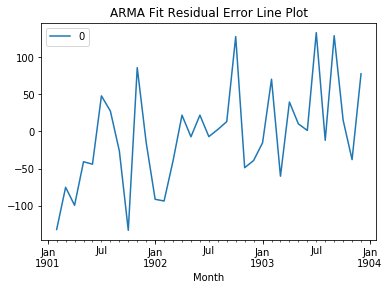

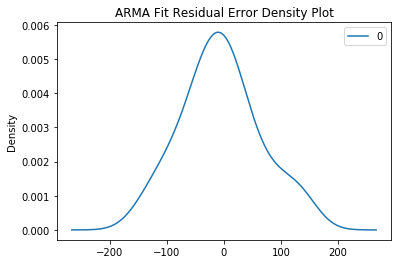

In [49]:
#Plot residual errors
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
plt.title('ARMA Fit Residual Error Line Plot')
residuals.plot(kind='kde')
plt.title('ARMA Fit Residual Error Density Plot')
print(residuals.describe())

#A line plot of the residual errors suggests that there may still be some trend information not captured by the model.
#Density plot of the residual error values suggests the errors are Gaussian, but may not be centered on zero.
#The distribution of the residual errors shows that indeed there is a bias in the prediction (a non-zero mean in the residuals).

In [50]:
#Rolling forecast ARIMA model
#Divide the data into train-test split
X = series.values
size = int(len(X) * 0.80)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]


In [51]:
#Fit an ARIMA(5,1,0) model. This sets the lag value to 5 for autoregression, uses a difference order of 1 to make the time series stationary, and uses a moving average model of 0.
predictions = list()
for t in range(len(test)):
    model = ARIMA(history, order=(5,1,0))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
    #Print the prediction and expected value each iteration.
    print('predicted=%f, expected=%f' % (yhat, obs))

predicted=356.082087, expected=401.300000
predicted=446.379462, expected=437.400000
predicted=394.737224, expected=575.500000
predicted=434.915402, expected=407.600000
predicted=507.923547, expected=682.000000
predicted=435.482779, expected=475.300000
predicted=652.743826, expected=581.300000
predicted=546.343519, expected=646.900000


In [52]:
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                   34
Model:                 ARIMA(5, 1, 0)   Log Likelihood                -190.136
Method:                       css-mle   S.D. of innovations             63.456
Date:                Fri, 05 Jul 2019   AIC                            394.273
Time:                        17:38:43   BIC                            404.957
Sample:                             1   HQIC                           397.916
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         11.2303      3.644      3.082      0.005       4.087      18.373
ar.L1.D.y     -1.0867      0.182     -5.967      0.000      -1.444      -0.730
ar.L2.D.y     -0.5923      0.279     -2.122      0.0

In [53]:
#Calculate mean squared error score (MSE) for the predictions
error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)

Test MSE: 10331.306


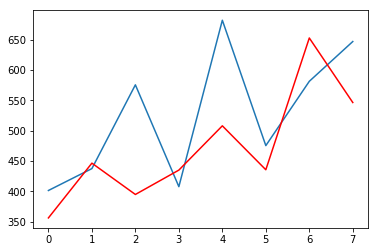

In [54]:
#Create a line plot showing the expected values (blue) compared to the rolling forecast predictions (red). 
#The values show some trend and are in the correct scale
plt.plot(test)
plt.plot(predictions, color='red')